<a href="https://colab.research.google.com/github/madhulathachavali/AIML/blob/main/ImageClassification_XrayCovid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data consists of training set and a test set of images of 3 classes. Each image has a filename that is its unique id. The dataset comprises 3 classes: COVID-19, Viral Pneumonia, and Normal. The goal of the project is to create a classifier to predict class of the X-ray image

I worked on this project as part of the AIML post-graduate program offered by the University of Texas, Austin.

In [1]:
import tensorflow as tf
import seaborn as sns

In [2]:
# Import necessary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
sns.set()

# Import necessary libraries.
import cv2
import math
from glob import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import keras
keras.__version__

'2.8.0'

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
trainImages = np.load('/content/drive/My Drive/ImageData/covid-19-dataset/trainimage.npy')
testImages = np.load('/content/drive/My Drive/ImageData/covid-19-dataset/testimage.npy')
trainLabels = pd.read_csv('/content/drive/My Drive/ImageData/covid-19-dataset/trainLabels.csv')
testLabels = pd.read_csv('/content/drive/My Drive/ImageData/covid-19-dataset/testLabels.csv')

In [6]:
print(trainImages.shape) # Print shape of the train and test images # 128 X 128 image pixel size, 3 means RGB
print(testImages.shape)


(251, 128, 128, 3)
(66, 128, 128, 3)


In [7]:
trainLabels.head(6)

,Label
0,Viral Pneumonia
1,Viral Pneumonia
2,Viral Pneumonia
3,Viral Pneumonia
4,Viral Pneumonia
5,Viral Pneumonia


In [8]:
trainLabels.info() #data type of each column and whether null values are present

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   251 non-null    object
dtypes: object(1)
memory usage: 2.1+ KB


In [9]:
trainLabels['Label'].value_counts()

Covid              111
Viral Pneumonia     70
Normal              70
Name: Label, dtype: int64

Image Data Visualization

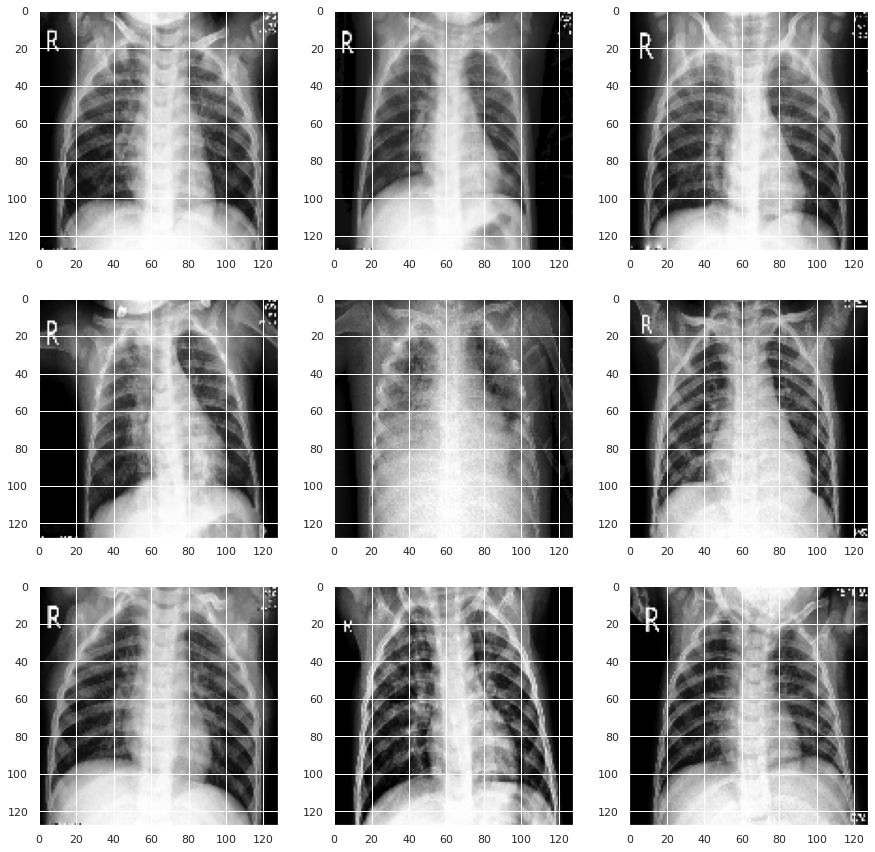

In [10]:
# Visualizing the some images
fig = plt.figure(figsize=(15, 15))  # width, height in inches

for i in range(9):
    sub = fig.add_subplot(3, 3, i + 1)
    sub.imshow(trainImages[i])

# Adjust subplot parameters to give specified padding
#plt.tight_layout()  

The dimensions of the image are 128 pixels width and 128 pixels height, one single color channel
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 115.7282 and the standard deviation is 79.8630


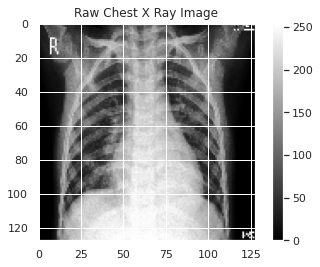

In [11]:
# Visualize a image using matplotlib
plt.imshow(trainImages[5], cmap='gray')

plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {trainImages[5].shape[0]} pixels width and {trainImages[5].shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {trainImages[5].max():.4f} and the minimum is {trainImages[5].min():.4f}")
print(f"The mean value of the pixels is {trainImages[5].mean():.4f} and the standard deviation is {trainImages[5].std():.4f}")

Text(-1.6650000000000063, 0.5, '# Pixels in Image')

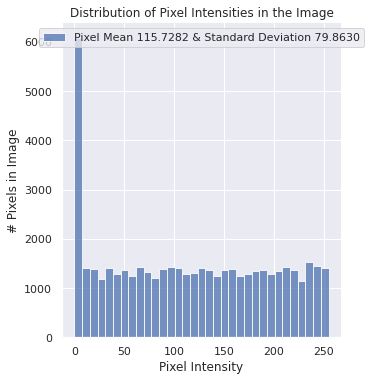

In [12]:
# Pixel Value Distribution

# Plot a histogram of the distribution of the pixels
# .ravel() changes a 2-dimensional array or a multi-dimensional array into a flattened array
sns.displot(trainImages[5].ravel(), 
             label=f'Pixel Mean {np.mean(trainImages[5]):.4f} & Standard Deviation {np.std(trainImages[5]):.4f}', kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

**Normalize data**
- The data is normalized before model building (both normalize X_train and X_test)
- this is done by by dividing the RGB codes with 255 (which is the maximum RGB code minus the minimum RGB code)
- convert into float as we get decimal points after division 

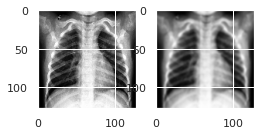

In [13]:
## Train Images Preprocessing 

preprocessed_train = []       # Initialize empty list to store the images after pre-processing.

for img in trainImages:
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
     
    
    preprocessed_train.append(blurImg)        # Append image 
    
    # Show examples

plt.subplot(1, 3, 1); plt.imshow(img)         # Show the original image
plt.subplot(1, 3, 2); plt.imshow(blurImg)     # Blur image

preprocessed_train = np.asarray(preprocessed_train)    # Convert to numpy array.


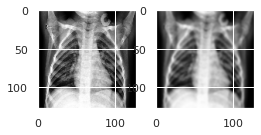

In [14]:

## Test Images Preprocessing 

preprocessed_test = []       # Initialize empty list to store the images after pre-processing.

for img in testImages:
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
     
    
    preprocessed_test.append(blurImg)        # Append image 
    
    # Show examples

plt.subplot(1, 3, 1); plt.imshow(img)         # Show the original image
plt.subplot(1, 3, 2); plt.imshow(blurImg)     # Blur image

preprocessed_test = np.asarray(preprocessed_test)    # Convert to numpy array.

In [15]:
# Normalize train image data by dividing the input image by 255 so that image value will be between 0 and 1
preprocessed_train = preprocessed_train / 255
# Normalize test image data.
preprocessed_test = preprocessed_test / 255

Comparison of the distribution of pixel values (Raw vs Preprocessed)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


Text(0, 0.5, '# Pixel')

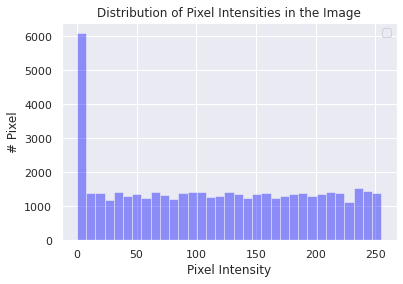

In [16]:
raw_image = trainImages[5]
# Plot histogram for original iamge
sns.distplot(trainImages[5].ravel(),color='blue',kde = False);
# Place legends
plt.legend()
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixel')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


Text(0, 0.5, '# Pixel')

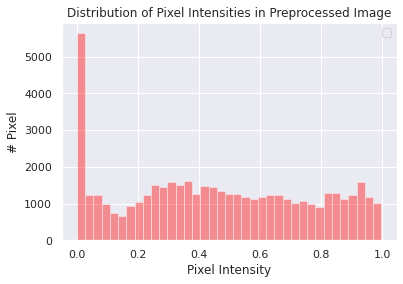

In [17]:
# Plot histogram for generated image
generated_image = preprocessed_train[5]
sns.distplot(preprocessed_train[5].ravel(),color='red', kde = False);
# Place legends
plt.legend()
plt.title('Distribution of Pixel Intensities in Preprocessed Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixel')



---

---

Counting labels



In [18]:
trainLabels['Label'].value_counts()

Covid              111
Viral Pneumonia     70
Normal              70
Name: Label, dtype: int64

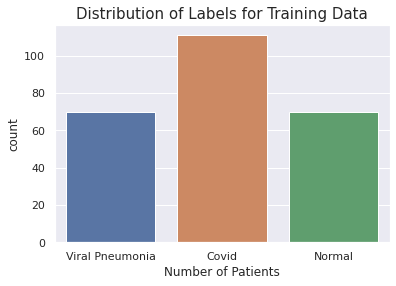

In [19]:
sns.countplot(x="Label", data=trainLabels)
plt.title('Distribution of Labels for Training Data', fontsize=15)
plt.xlabel('Number of Patients', fontsize=12)
plt.show()

In [20]:

# Label encoding categorical to numerical
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train = enc.fit_transform(trainLabels)

In [21]:
enc.classes_

array(['Covid', 'Normal', 'Viral Pneumonia'], dtype='<U15')

In [22]:
y_test = enc.fit_transform(testLabels)

In [23]:
X_train = preprocessed_train
X_test = preprocessed_test

In [24]:
# Reshape data into shapes compatible with Keras models.

X_train = X_train.reshape(X_train.shape[0], 128, 128, 3)
X_test = X_test.reshape(X_test.shape[0], 128, 128, 3)

In [25]:
# Set the CNN model 

batch_size = None

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', batch_input_shape = (batch_size, 128, 128, 3)))


model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.4))

model.add(GlobalMaxPooling2D())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(3, activation = "softmax"))

In [26]:
optimizer = Adam(learning_rate=0.001,
                  beta_1=0.9,
                  beta_2=0.999,
                  epsilon=1e-07,
                  amsgrad=False,
                  name='Adam')
# Compile the model 
model.compile(optimizer = optimizer, loss = tf.keras.losses.BinaryCrossentropy(),metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalseNegatives()])

In [27]:
# Set epochs = 40, and fit the model.
history = model.fit(X_train, y_train, epochs = 40, validation_split=0.2, batch_size = batch_size)

Epoch 1/40
7/7 [==============================] - 16s 234ms/step - loss: 0.6136 - binary_accuracy: 0.6850 - false_negatives: 137.0000 - val_loss: 0.7423 - val_binary_accuracy: 0.6667 - val_false_negatives: 51.0000
Epoch 2/40
7/7 [==============================] - 0s 54ms/step - loss: 0.5999 - binary_accuracy: 0.6617 - false_negatives: 153.0000 - val_loss: 0.7993 - val_binary_accuracy: 0.6667 - val_false_negatives: 51.0000
Epoch 3/40
7/7 [==============================] - 0s 53ms/step - loss: 0.5750 - binary_accuracy: 0.6950 - false_negatives: 123.0000 - val_loss: 0.8020 - val_binary_accuracy: 0.6667 - val_false_negatives: 51.0000
Epoch 4/40
7/7 [==============================] - 0s 54ms/step - loss: 0.5422 - binary_accuracy: 0.7450 - false_negatives: 87.0000 - val_loss: 0.9460 - val_binary_accuracy: 0.3791 - val_false_negatives: 51.0000
Epoch 5/40
7/7 [==============================] - 0s 51ms/step - loss: 0.5058 - binary_accuracy: 0.7133 - false_negatives: 90.0000 - val_loss: 0.8587 -

In [32]:
# Accuracy and loss for train data
train_score = model.evaluate(X_train, y_train, verbose=0, batch_size = 38)
print('Train loss:', train_score[0])
print('Train accuracy:', train_score[1])

Train loss: 0.20587407052516937
Train accuracy: 0.9256308674812317


In [28]:
# Evaluate the model on test data

score = model.evaluate(X_test, y_test, verbose=0, batch_size = 38)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4156055748462677
Test accuracy: 0.8181818127632141


Modeling Summary:

We created a CNN classifier that can predict the class of Xray with 92% accuracy (0.2 loss) on train data and 82% (0.4 loss) on test data.

